# Why are our customers churning?

-The following notebook is the culmination of indepth analysis of churn data pulled from the company SQL server. 
The data was pulled in, cleaned and explored to find the features most likely to predict churn.
Once those features were identified, they were fed into 4 models:
- Logistic regression
- Single decision tree
- Random Forest 
- K Nearest Neighbors

The best model was selected and a presentation of the final results and recomendations can be found in the README.md of this repository. 

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import acquire
import wrangle
import model

# Step 1: Aquire the data

- The data can be pulled in from a function called __get_telco_data__ which runs a SQL query of the telco_churn database. The results are comprised of features from four tables:
> - contract_types
> - internet_service_types
> - customers
> - payment_types
- The results were then converted to a pandas dataframe. The function is stored in acuire.py and imported to this notebook

In [2]:
df = acquire.get_telco_data()
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn
0,0002-ORFBO,Female,0,Yes,Yes,9,65.6,593.3,Yes,No,...,Yes,No,Yes,Yes,No,Yes,2,2,1,No
1,0003-MKNFE,Male,0,No,No,9,59.9,542.4,Yes,Yes,...,No,No,No,No,Yes,No,1,2,1,No
2,0004-TLHLJ,Male,0,No,No,4,73.9,280.85,Yes,No,...,No,Yes,No,No,No,Yes,1,1,2,Yes
3,0011-IGKFF,Male,1,Yes,No,13,98.0,1237.85,Yes,No,...,Yes,Yes,No,Yes,Yes,Yes,1,1,2,Yes
4,0013-EXCHZ,Female,1,Yes,No,3,83.9,267.4,Yes,No,...,No,No,Yes,Yes,No,Yes,1,2,2,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
monthly_charges             7043 non-null float64
total_charges               7043 non-null object
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing           7043 non-null object
contract_type_id            7043 non-null int64
payment_type_

- The dataframe has 7,043 observations and 21 features with data types including object, int64 and float64.

# Step 2: Preparation

- The following changes are applied to the dataframe via the __wrangle_telco__ function store in the wrangle.py file:
> - Monthly charges column is based on the tenure column. There were several null values in the tenure column and we assumed that meant the customer was at the company for less than one month but likely would still be charged for at least one month of services. So the nulls were filled with a tenure of 1 and the value for monthly charges were set to that of other customers with a tenure of 1.
> - A boolean column of automatic payment types was added that indicates if the customer uses an automatic form of payment
> - A column of total_charges_scaled was added for the purposes of vizualization and modeling
> - Another boolean columnn of tenure_less_than_8 indicates if the customer has been a part of the company for less than 8 months

- A description of the rest of the features can be found in the data dictionary in the README.md

In [4]:
df = wrangle.wrangle_telco()
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn,automatic_payment,monthly_charges_scaled,tenure_3_or_less
0,0002-ORFBO,Female,0,Yes,Yes,9,65.6,593.30,Yes,No,...,Yes,No,Yes,2,2,1,No,False,0.471144,False
1,0003-MKNFE,Male,0,No,No,9,59.9,542.40,Yes,Yes,...,No,Yes,No,1,2,1,No,False,0.414428,False
2,0004-TLHLJ,Male,0,No,No,4,73.9,280.85,Yes,No,...,No,No,Yes,1,1,2,Yes,False,0.553731,False
3,0011-IGKFF,Male,1,Yes,No,13,98.0,1237.85,Yes,No,...,Yes,Yes,Yes,1,1,2,Yes,False,0.793532,False
4,0013-EXCHZ,Female,1,Yes,No,3,83.9,267.40,Yes,No,...,Yes,No,Yes,1,2,2,Yes,False,0.653234,True


In [5]:
# split the data into train and test for encoding, exploration and modeling
train, test = train_test_split(df, random_state=123, train_size=.86)

In [6]:
# encoding: loop w/ list of columns to encode
encoder = LabelEncoder()

encode_list = [
    'gender', 'partner', 'dependents', 'phone_service'
    , 'multiple_lines', 'online_security', 'online_backup'
    , 'device_protection', 'tech_support'
    , 'streaming_movies', 'streaming_tv', 'paperless_billing', 'churn'
    ]
               
               
               
for e in encode_list:
    train[e] = encoder.fit_transform(train[e])
    test[e] = encoder.transform(test[e])

In [7]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn,automatic_payment,monthly_charges_scaled,tenure_3_or_less
2364,3389-KTRXV,0,0,1,1,23,23.85,625.65,1,2,...,1,1,0,3,2,3,0,False,0.055721,False
6550,9300-RENDD,1,0,0,0,1,79.95,79.95,1,0,...,2,0,1,1,1,2,1,False,0.613930,True
1971,2853-CWQFQ,1,0,0,1,1,59.55,59.55,1,0,...,0,2,1,1,2,1,0,False,0.410945,True
335,0495-RVCBF,0,0,0,0,1,79.70,79.70,1,0,...,0,2,1,1,1,2,1,False,0.611443,True
5662,7979-CORPM,1,0,0,0,24,90.55,2282.55,1,2,...,2,0,1,1,4,2,1,True,0.719403,False


In [8]:
train.shape

(6056, 24)

# Step 3: Exploration

During this section, the team identified patterns in the data which may help to isolate which features were most helpful in predicting churn. 

- First we looked at tenure and total_charges_scaled at potential indicators of churn.

### First Hypothesis
- $H_0$: Tenure has no effect on churn rate
- $H_a$: Tenure does have an effect on churn rate
- alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

In [9]:
X1 = train[train.churn == 1].tenure
X2 = train[train.churn == 0].tenure
stats.ttest_ind(X1, X2)

Ttest_indResult(statistic=-29.61955136533476, pvalue=3.565872109230304e-180)

#### Interpretation of t statistic and p value needed here

In [10]:
# How many people have churned?
train.churn.value_counts()

0    4457
1    1599
Name: churn, dtype: int64

In [11]:
# Which contract type has the highest number of people churning?
train.groupby(['churn']).contract_type_id.value_counts()

churn  contract_type_id
0      1                   1919
       3                   1421
       2                   1117
1      1                   1421
       2                    133
       3                     45
Name: contract_type_id, dtype: int64

- Of the people who have churned, the majority of them (1,421) had a month-to-month contract. Why?
- Let's add in payment types

In [12]:
train.groupby(['churn','contract_type_id']).payment_type_id.value_counts()

churn  contract_type_id  payment_type_id
0      1                 1                  740
                         2                  520
                         3                  339
                         4                  320
       2                 3                  303
                         4                  296
                         2                  274
                         1                  244
       3                 4                  491
                         3                  474
                         2                  325
                         1                  131
1      1                 1                  848
                         2                  245
                         3                  172
                         4                  156
       2                 1                   50
                         4                   36
                         3                   31
                         2                   16

- It looks like the non-automatic payment types account for the highest number of people who have churned.
- This is why we added in the column indicating if the payment type is automatic or not

In [13]:
# code to regulate the size of plots for the rest of notebook
plt.rc('figure', figsize=(13, 10))
plt.rc('font', size=13)

([<matplotlib.axis.XTick at 0x1a26c66790>,
 [Text(0, 0, 'Churned Customers'), Text(0, 0, 'Retained Customers')])

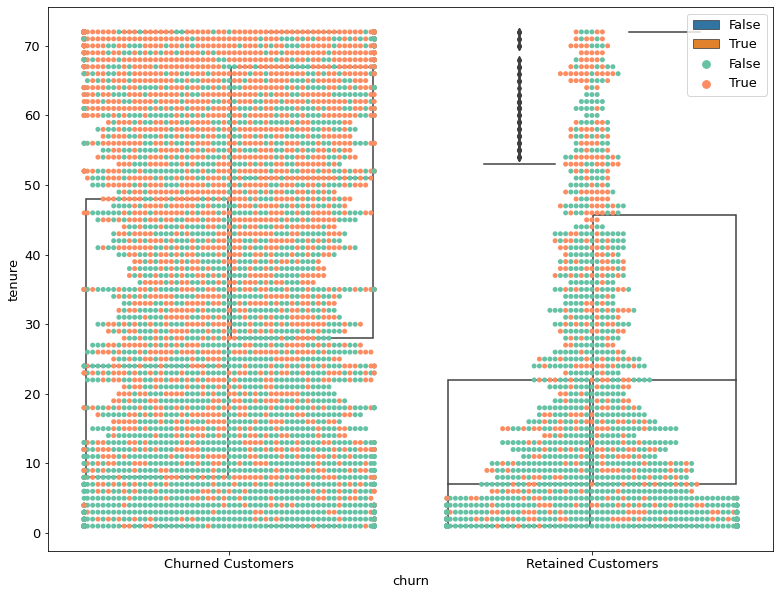

In [14]:
# At what point in their tenure do customers tend to churn the most and what payment type do they typically use?
sns.swarmplot(x="churn", y="tenure", data=train, hue = "automatic_payment", palette="Set2")
ax = sns.boxplot(x="churn", y="tenure", data=train, hue = "automatic_payment",
        showcaps=True,boxprops={'facecolor':'None'},
        showfliers=True,whiskerprops={'linewidth':0})
plt.legend(loc=1)

plt.xticks([0, 1],['Churned Customers', 'Retained Customers'])

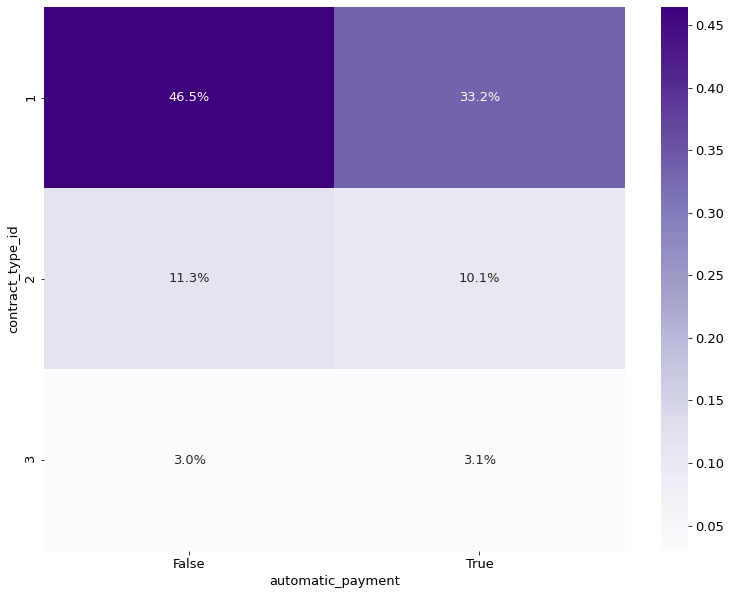

In [15]:
#Of the people who have churned, what payment type do they typically use
plt.rc('figure', figsize=(13, 10))
plt.rc('font', size=13)
ctab = pd.crosstab(train.contract_type_id, train.automatic_payment, values=train.churn, aggfunc='mean')
sns.heatmap(ctab, annot=True, cmap='Purples', fmt='.1%')

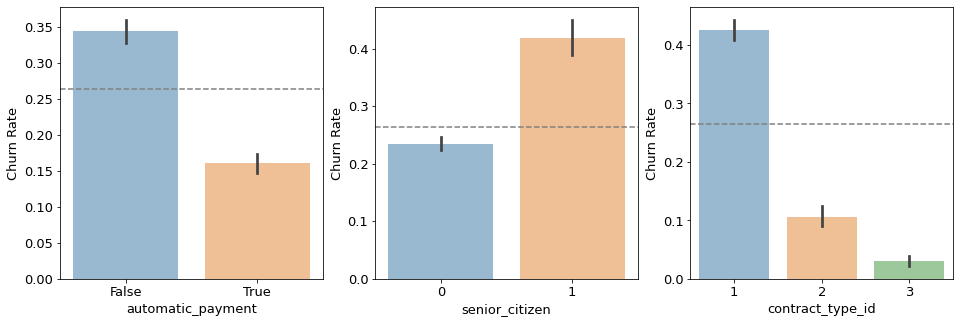

In [16]:
# 3 barplots depicting who is churning
# in the senior citizen bar plot, 0 = not a senior citizen 1 = is a senior citizen
# for our contract type id, 1 = month to month, 2 = year long contract, 3 = two year long contract
features = ['automatic_payment', 'senior_citizen', 'contract_type_id']
            
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

churn_rate = train.churn.mean()

for i, feature in enumerate(features):
    sns.barplot(feature, 'churn', data=train, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Churn Rate')
    ax[i].axhline(churn_rate, ls='--', color='grey')
    



## Who is churning?
- customers not enrolled in our auto-bill payment program
- customers with month-to-month contract types
- senior citizens

In [17]:
# of people churning in the first 3 months
churn_in_3 = df[df.tenure <= 3]

churn_in_3.count()

customer_id                 1062
gender                      1062
senior_citizen              1062
partner                     1062
dependents                  1062
tenure                      1062
monthly_charges             1062
total_charges               1062
phone_service               1062
multiple_lines              1062
online_security             1062
online_backup               1062
device_protection           1062
tech_support                1062
streaming_tv                1062
streaming_movies            1062
paperless_billing           1062
contract_type_id            1062
payment_type_id             1062
internet_service_type_id    1062
churn                       1062
automatic_payment           1062
monthly_charges_scaled      1062
tenure_3_or_less            1062
dtype: int64

In [18]:
# percentage of people churning in first 3 months
1062 / 7043

0.15078801647025417

In [19]:
churn_in_3.automatic_payment.value_counts()

False    912
True     150
Name: automatic_payment, dtype: int64

In [20]:
# percentage of people not enrolled in our automatic payment plan of those who churned in 3 months or less
912 / 1062

0.8587570621468926

In [21]:
# percentage of those churning in the first month of those churning in 3
624 / 1062

0.5875706214689266

>15% of our customers are churning in the first 3 months of service, 58% of those who churn in the first 3 months are churning in the first month of service

In [22]:
churn_in_6 = df[df.tenure <= 6]

churn_in_6.count()

customer_id                 1481
gender                      1481
senior_citizen              1481
partner                     1481
dependents                  1481
tenure                      1481
monthly_charges             1481
total_charges               1481
phone_service               1481
multiple_lines              1481
online_security             1481
online_backup               1481
device_protection           1481
tech_support                1481
streaming_tv                1481
streaming_movies            1481
paperless_billing           1481
contract_type_id            1481
payment_type_id             1481
internet_service_type_id    1481
churn                       1481
automatic_payment           1481
monthly_charges_scaled      1481
tenure_3_or_less            1481
dtype: int64

In [23]:
churn_in_6.senior_citizen.value_counts()

0    1264
1     217
Name: senior_citizen, dtype: int64

In [24]:
churn_in_6.automatic_payment.value_counts()

False    1236
True      245
Name: automatic_payment, dtype: int64

In [25]:
# percentage of customers churning in first 6 months
1481 / 7043

0.21027971035070284

In [26]:
# percentage of those leaving in the first 3 months of those churning in 6
1062 / 1481 

0.7170830519918974

In [27]:
# percentage of churned customers that are not enrolled in auto paying
1264 / 1481

0.8534773801485482

In [28]:
# percentage of customers churning in 1 month
churn_in_1 = df[df.tenure == 1]

churn_in_1.count()

customer_id                 624
gender                      624
senior_citizen              624
partner                     624
dependents                  624
tenure                      624
monthly_charges             624
total_charges               624
phone_service               624
multiple_lines              624
online_security             624
online_backup               624
device_protection           624
tech_support                624
streaming_tv                624
streaming_movies            624
paperless_billing           624
contract_type_id            624
payment_type_id             624
internet_service_type_id    624
churn                       624
automatic_payment           624
monthly_charges_scaled      624
tenure_3_or_less            624
dtype: int64

In [29]:
churn_in_1.automatic_payment.value_counts()

False    555
True      69
Name: automatic_payment, dtype: int64

In [30]:
# 12 percent of customers who're churning in 1 month are enrolled in auto payments
69 / 555

0.12432432432432433

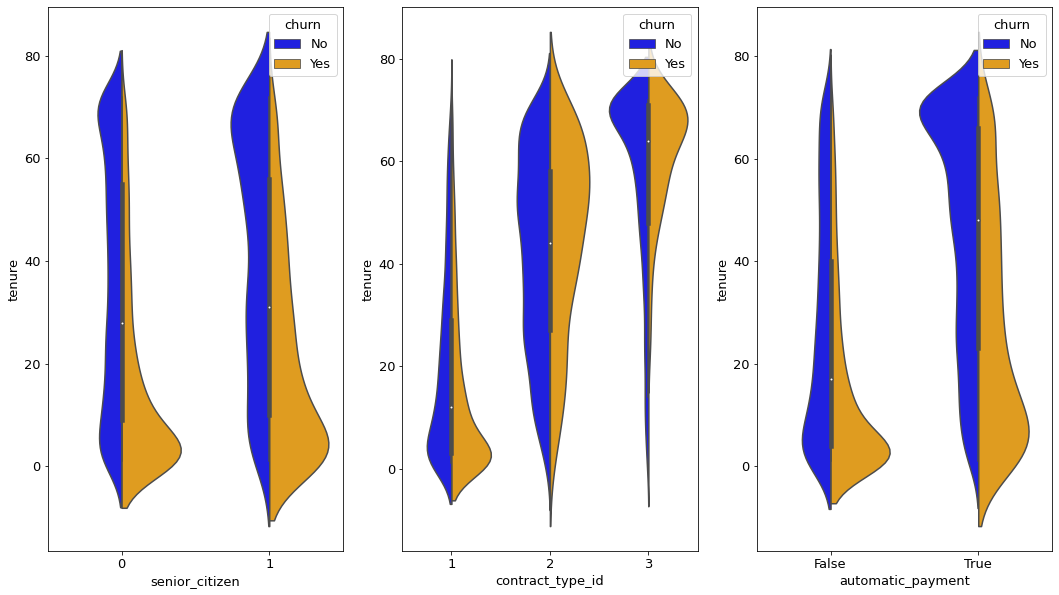

In [31]:
features = ['senior_citizen', 'contract_type_id', 'automatic_payment']
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,10))

for i, feature in enumerate(features):
    sns.violinplot(feature, 'tenure', hue='churn',
        data=df, split=True, ax=ax[i], palette=['blue','orange'])

Text(0.5, 1.0, 'Monthly Charges x Churn rate')

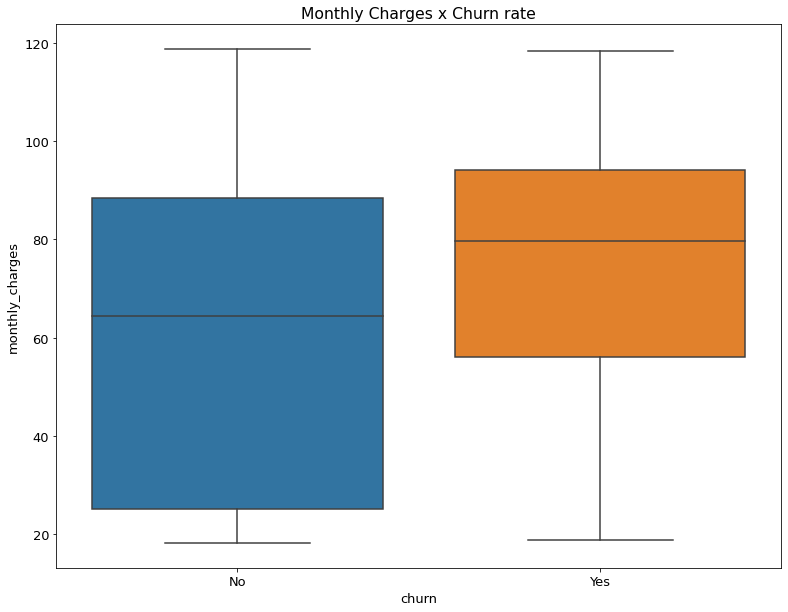

In [32]:
# distribution of churn
sns.boxplot(x='churn', y='monthly_charges', data=df)
plt.title('Monthly Charges x Churn rate')

In [33]:
# encoded churn column, 0 = churn, 1 = current customer
encoder = LabelEncoder()
encoder.fit(df.churn)
df.encoded = encoder.transform(df.churn)

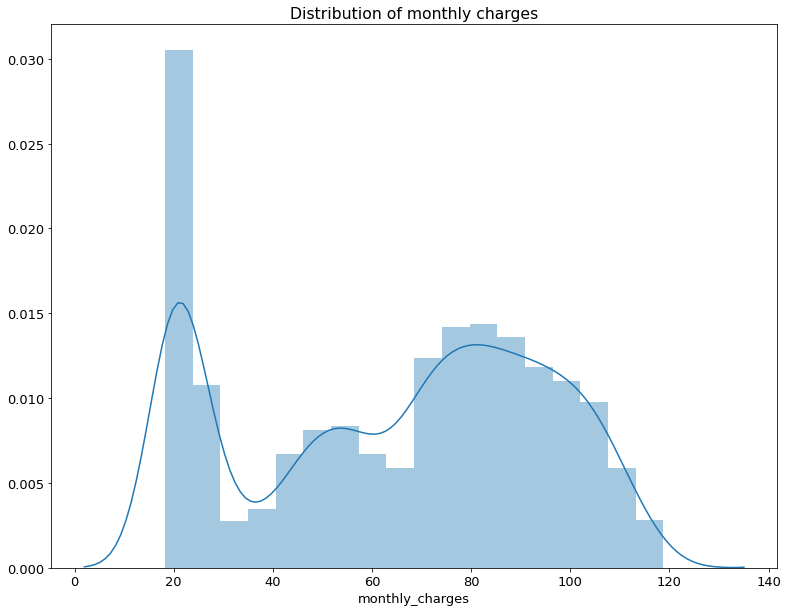

In [34]:
# distribution rate for how much people are paying monthly
x = df.monthly_charges
sns.distplot(x)
plt.title('Distribution of monthly charges')
plt.show()

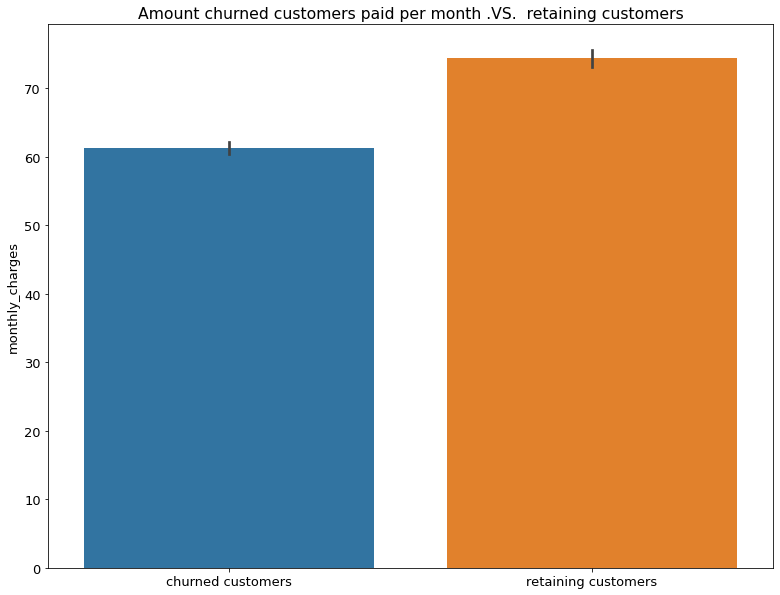

In [35]:
# barplot showing us how much people are paying per month who churn and who dont churn
sns.barplot(y=df.monthly_charges, x=df.encoded)
plt.title('Amount churned customers paid per month .VS.  retaining customers')
plt.xticks([0, 1],['churned customers', 'retaining customers'])
plt.show()

# Second Hypothesis
- $H_0$: people who churn are paying more per month than those who arent\
- $H_a$: people who churn are paying the same or less than those who dont churn
- alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

In [36]:
# lets run a t-test to see what the probability of someone churning paying more per month
churners = df[df.churn == 'Yes']
t, p = stats.ttest_1samp(churners.monthly_charges, df.monthly_charges.mean())

print(f't = {t:.3f}')
print(f'p = {p:.61f}')

t = 16.965
p = 0.0000000000000000000000000000000000000000000000000000000000037


In [37]:
not_churners = df[df.churn == 'No']

churners.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn,automatic_payment,monthly_charges_scaled,tenure_3_or_less
2,0004-TLHLJ,Male,0,No,No,4,73.9,280.85,Yes,No,...,No,No,Yes,1,1,2,Yes,False,0.553731,False
3,0011-IGKFF,Male,1,Yes,No,13,98.0,1237.85,Yes,No,...,Yes,Yes,Yes,1,1,2,Yes,False,0.793532,False
4,0013-EXCHZ,Female,1,Yes,No,3,83.9,267.40,Yes,No,...,Yes,No,Yes,1,2,2,Yes,False,0.653234,True
18,0022-TCJCI,Male,1,No,No,45,62.7,2791.50,Yes,No,...,No,Yes,No,2,4,1,Yes,True,0.442289,False
19,0023-HGHWL,Male,1,No,No,1,25.1,25.10,No,No phone service,...,No,No,Yes,1,1,1,Yes,False,0.068159,True


In [38]:
print(f"People who churn are paying ${churners.monthly_charges.mean():.2f} per month with a median of ${churners.monthly_charges.median()}")
print(f"The avg per month for all customers ${df.monthly_charges.mean():.2f}, and per month with a median of ${df.monthly_charges.median()}")
print(f"People who are still with us are paying ${not_churners.monthly_charges.mean():.2f} per month with a median of ${not_churners.monthly_charges.median():.2f}")

People who churn are paying $74.44 per month with a median of $79.65
The avg per month for all customers $64.76, and per month with a median of $70.35
People who are still with us are paying $61.27 per month with a median of $64.43


In [39]:
# percentage of customers who havent churned that are enroll in auto payment
not_churners.automatic_payment.value_counts()

False    2598
True     2576
Name: automatic_payment, dtype: int64

In [40]:
2598 / (2598 + 2576)

0.5021260146888288

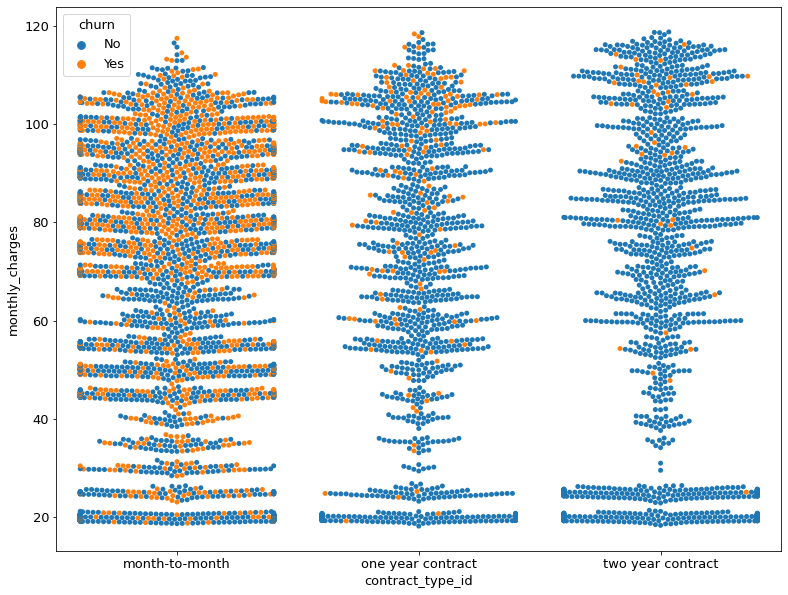

In [41]:
sns.swarmplot(y=df.monthly_charges, x=df.contract_type_id, hue=df.churn)
plt.xticks([0, 1, 2],['month-to-month', 'one year contract', 'two year contract'])
plt.show()

In [42]:
df.contract_type_id.value_counts()

1    3875
3    1695
2    1473
Name: contract_type_id, dtype: int64

In [43]:
3875 /2

1937.5

# Modeling

In [44]:
train, validate = train_test_split(train, random_state=123, test_size=.2)


X_train = train[['contract_type_id', 'senior_citizen',  'tenure_3_or_less', 'monthly_charges_scaled', 'payment_type_id']]
y_train = train[['churn']]
X_val = validate[['contract_type_id', 'senior_citizen', 'tenure_3_or_less', 'monthly_charges_scaled', 'payment_type_id']]
y_val = validate[['churn']]
X_test = test[['contract_type_id', 'senior_citizen',  'tenure_3_or_less', 'monthly_charges_scaled', 'payment_type_id']]
y_test = test[['churn']]

In [45]:
# fitting our model to our logit model
logit = LogisticRegression(random_state = 123)
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
# creating our confusion matrix
y_pred = logit.predict(X_train)
pd.DataFrame(confusion_matrix(y_train, y_pred))

,0,1
0,3229,354
1,723,538


In [47]:
# fitting our data to our Decision Tree model
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=123)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [48]:
# creating our confusion matrix
y_pred = clf.predict(X_train)
pd.DataFrame(confusion_matrix(y_train, y_pred))

,0,1
0,3504,79
1,1035,226


In [49]:
# fitting our data to our KNearest Neighbors model
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [50]:
# creating our confusion matrix
y_pred = knn.predict(X_train)
pd.DataFrame(confusion_matrix(y_train, y_pred))

,0,1
0,3269,314
1,557,704


In [51]:
# fitting our data to our random forest model
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [52]:
# creating our confusion matrix
y_pred = rf.predict(X_train)
pd.DataFrame(confusion_matrix(y_train, y_pred))

,0,1
0,3391,192
1,898,363


In [53]:
#Create a dataframe with all the model predictions
model_df = test[['churn']]
model_df = model_df.rename(columns={"churn": "actual"})
model_df.head()

,actual
941,0
1404,0
5515,0
3684,1
7017,0


In [54]:
# Programmatically assign the value of the most frequent 
model_df["baseline"] = model_df.actual.value_counts().index[0]
model_df.head()

,actual,baseline
941,0,0
1404,0,0
5515,0,0
3684,1,0
7017,0,0


In [55]:
model_df["Logit_Classifier"] = logit.predict(X_test)
model_df["Decision_Tree"] = clf.predict(X_test)
model_df['KNearest_Neighbors'] = knn.predict(X_test)
model_df['Random_Forest'] = rf.predict(X_test)
model_df.head()

,actual,baseline,Logit_Classifier,Decision_Tree,KNearest_Neighbors,Random_Forest
941,0,0,0,0,0,0
1404,0,0,0,0,0,0
5515,0,0,0,0,0,0
3684,1,0,1,1,1,1
7017,0,0,1,0,1,1


In [56]:
logit_classification_report = model.logit_metrics(train, test)

               precision    recall  f1-score   support

did not churn       0.81      0.90      0.85       717
        churn       0.63      0.44      0.52       270

     accuracy                           0.78       987
    macro avg       0.72      0.67      0.69       987
 weighted avg       0.76      0.78      0.76       987



In [57]:
decision_tree_classification_report = model.decision_tree_metrics(train, test)

               precision    recall  f1-score   support

did not churn       0.76      0.98      0.86       717
        churn       0.77      0.18      0.29       270

     accuracy                           0.76       987
    macro avg       0.77      0.58      0.57       987
 weighted avg       0.76      0.76      0.70       987



In [58]:
knn_classification_report = model.knn_metrics(train,test)

               precision    recall  f1-score   support

did not churn       0.81      0.88      0.85       717
        churn       0.59      0.47      0.52       270

     accuracy                           0.77       987
    macro avg       0.70      0.67      0.68       987
 weighted avg       0.75      0.77      0.76       987



In [59]:
random_forest_classification_report = model.rf_metrics(train, test)

               precision    recall  f1-score   support

did not churn       0.78      0.96      0.86       717
        churn       0.70      0.27      0.39       270

     accuracy                           0.77       987
    macro avg       0.74      0.61      0.62       987
 weighted avg       0.75      0.77      0.73       987



In [60]:
model.model_accuracy(model_df)

,model,accuracy%
1,Logit_Classifier,78.723404
4,Random_Forest,77.406282
2,Decision_Tree,76.089159
3,KNearest_Neighbors,74.468085
0,baseline,72.644377


In [61]:
predictions = pd.DataFrame(df.customer_id)

In [62]:
X = df[['contract_type_id', 'senior_citizen',  'tenure_3_or_less', 'monthly_charges_scaled', 'payment_type_id']]

In [63]:
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
y_pred_proba = logit.predict_proba(X)
y_pred_logit = logit.predict(X)

In [65]:
predictions = pd.DataFrame(
    {'Customer_ID': df.customer_id,
    'Probability_of_churn': y_pred_proba[:,1],
    'Probability_of_not_churning': y_pred_proba[:,0],
    'Churn_Prediction': y_pred_logit})

In [66]:
predictions.to_csv('telco_churn_predictions.csv')